In [187]:
library(igraph)

In [503]:
# Helper Functions

add_ego_node = function(graph,name) {
    # Add the new node
    graph = add.vertices(graph,1,name=name)
    
    new_edge_list = rep(0, 2*vcount(graph))
    for (i in 1:length(new_edge_list)) {
        if (i %% 2 == 0) {
            new_edge_list[i] = i/2
        }
        else {
            new_edge_list[i] = vcount(graph)
        }
    }
    
    # Add the edges
    graph = add_edges(graph, new_edge_list)
    
    return(graph)
}

get_entropy = function(count_vector, N) {
    entropy = 0
    for (i in 1:length(count_vector)) {
        if (count_vector[i] != 0) {
            entropy = entropy + -(count_vector[i]/N)*log2(count_vector[i]/N)
        }
    }
    return(entropy)
}

In [189]:
GPLUS_PATH = "gplus/"

data = read.delim("gplus/110701307803962595019.circles",sep="\n",header=FALSE)

In [190]:
# QUESTION 18

In [191]:
file_list = list.files(GPLUS_PATH)

graph_count = 0
over_two_circles_count = 0
# Read in files from gplu
for (i in 1:length(file_list_1)) {
    filename = paste(GPLUS_PATH, file_list[i], sep="")
    file_type = unlist(strsplit(filename,'\\.'))[2]
    if (file_type == "edges") {
        graph_count = graph_count + 1
    }
    else if (file_type == "circles") {
        circle_data = try(read.delim(filename,sep="\n",header=FALSE))
        if (!inherits(circle_data,'try-error')) circle_data
        if (length(unlist(circle_data)) > 2) {
            over_two_circles_count = over_two_circles_count + 1
        }
    }
}
print(paste("Total Number of Personalized Networks:",graph_count))
print(paste("Number of Personzlied Networks for Users With More Than 2 Circles:",over_two_circles_count))


[1] "Total Number of Personalized Networks: 132"
[1] "Number of Personzlied Networks for Users With More Than 2 Circles: 57"


In [192]:
# QUESTION 19, 20

In [193]:
NODE_IDS = c("109327480479767108490", "115625564993990145546", "101373961279443806744")


[1] "Modularity:  0.252780646085739"


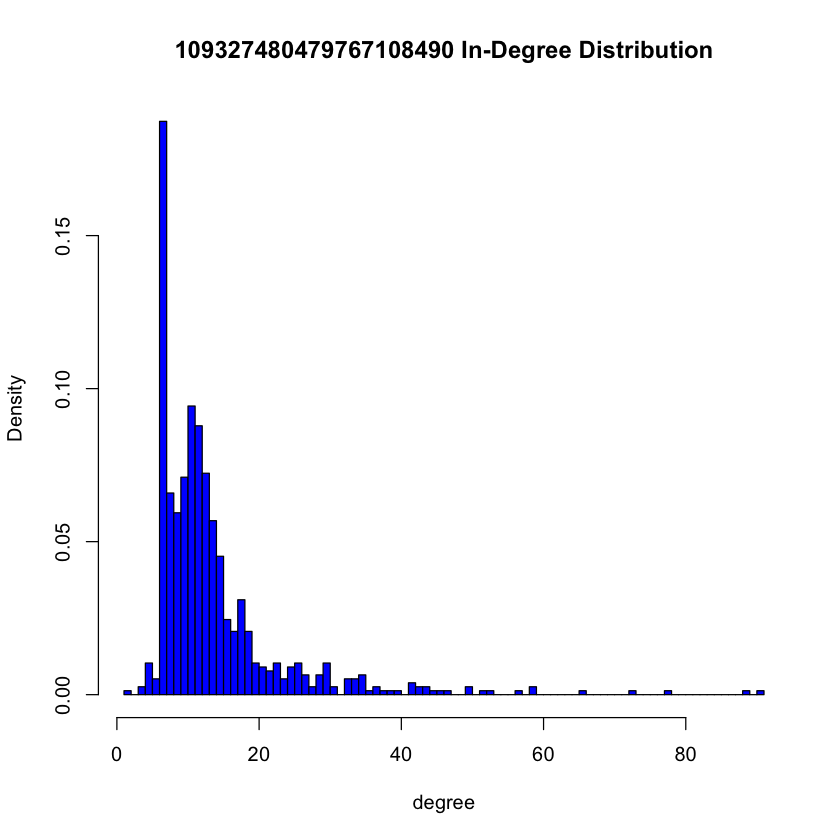

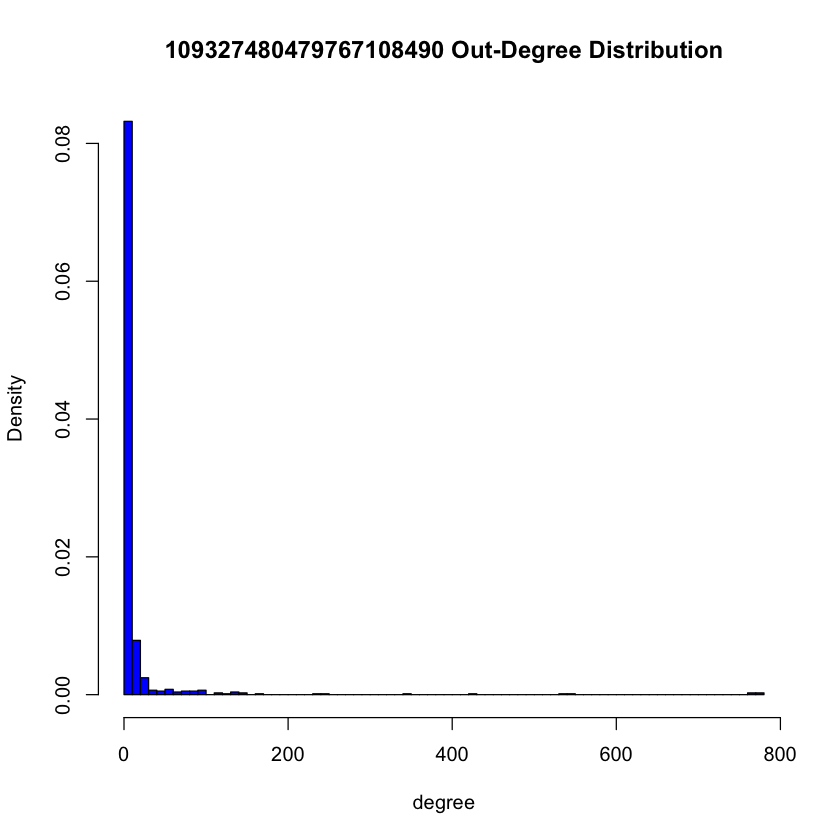

[1] "Modularity:  0.319473803043365"


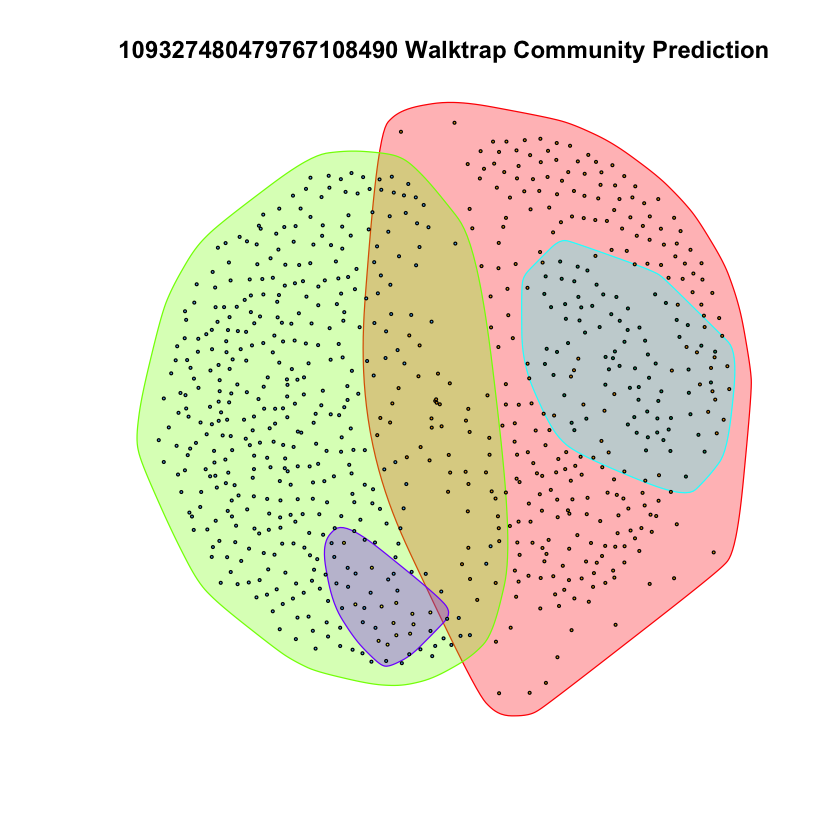

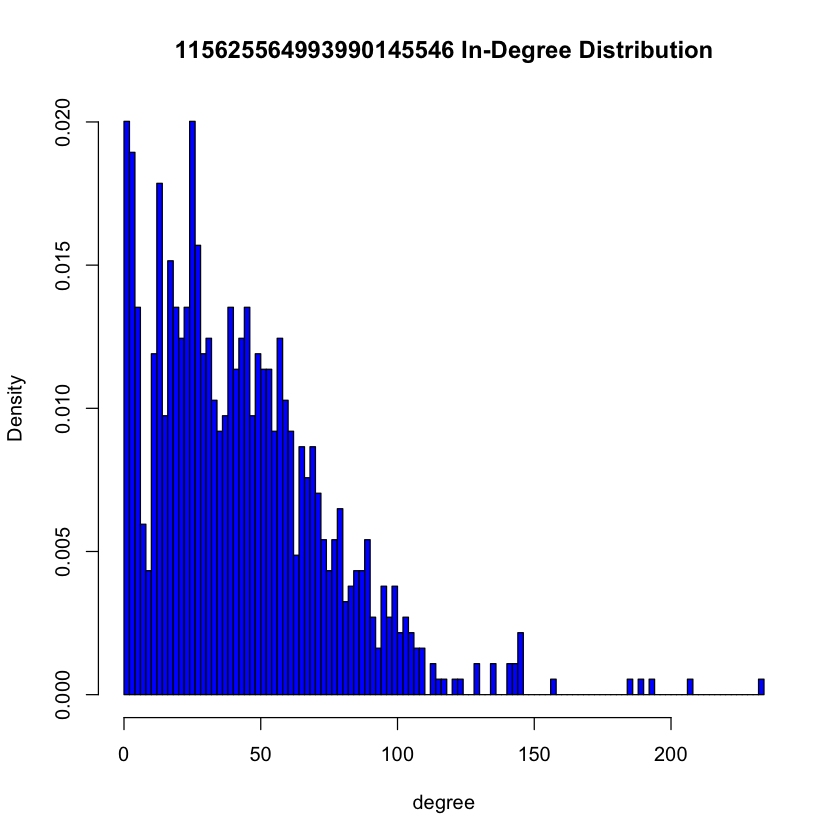

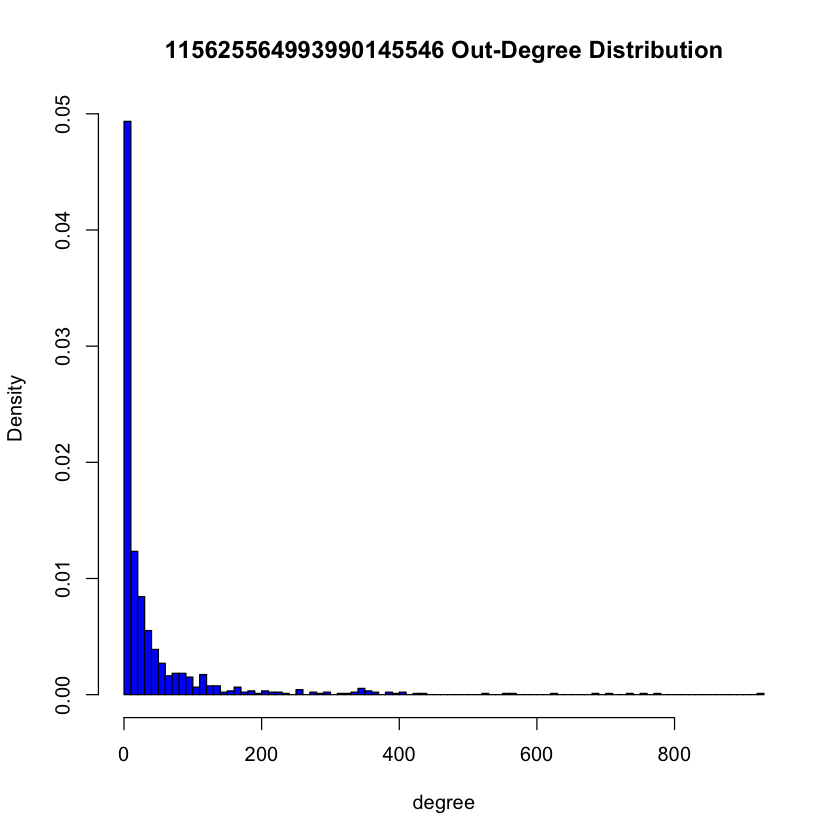

[1] "Modularity:  0.191093370318413"


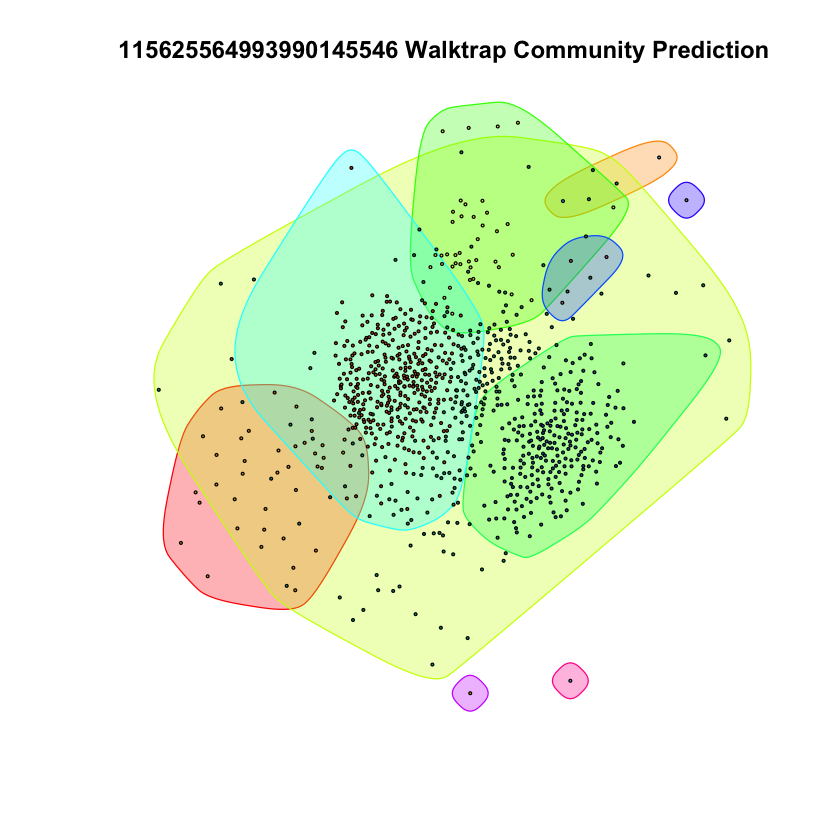

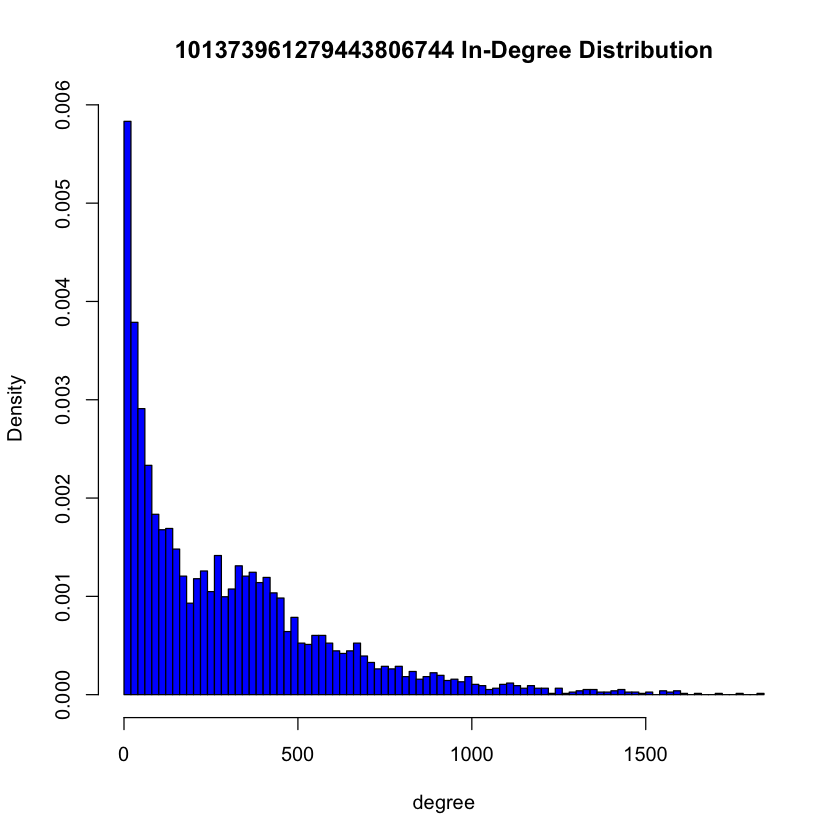

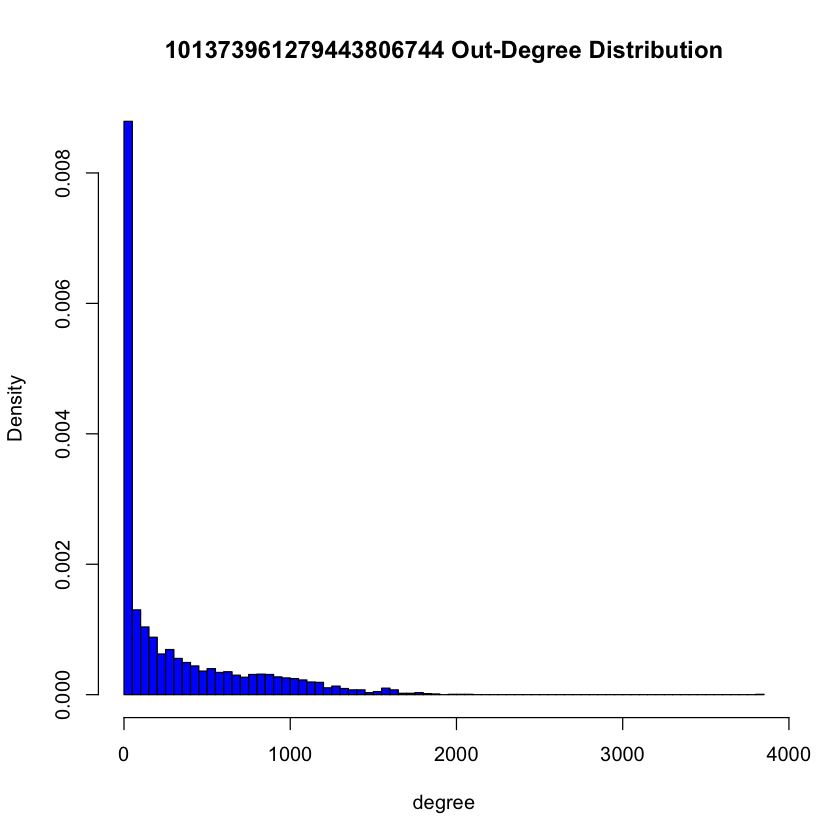

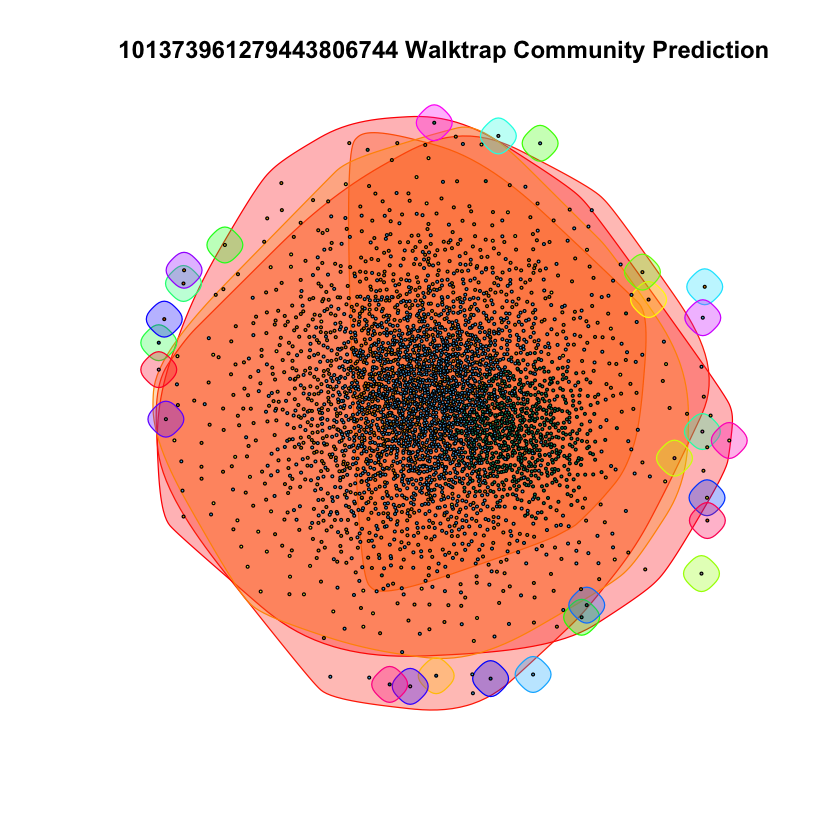

In [249]:
for (i in 1:length(NODE_IDS)) {
    filename = paste(getwd(),'/',GPLUS_PATH,NODE_IDS[i],'.edges',sep="")
    g = read_graph(filename,format="ncol",directed=TRUE)
    g = add_ego_node(g,name=NODE_IDS[i])
    comm = cluster_walktrap(g)
    print(paste("Modularity: ",modularity(comm)))
    hist(degree(g,mode="in"),breaks=100,freq=FALSE,col="blue",xlab="degree",main=paste(NODE_IDS[i],"In-Degree Distribution"))
    hist(degree(g,mode="out"),breaks=100,freq=FALSE,col="blue",xlab="degree",main=paste(NODE_IDS[i],"Out-Degree Distribution"))
    plot(comm,g,vertex.size=1,vertex.label=NA,width=0,edge.arrow.mode=0,edge.lty=0,main=paste(NODE_IDS[i],"Walktrap Community Prediction"))
}

In [ ]:
# QUESTION 21

In [ ]:
# Cluster the personalized network with Walktrap
CURRENT_NODE_IDX = 3
filename = paste(getwd(),'/',GPLUS_PATH,NODE_IDS[CURRENT_NODE_IDX],'.edges',sep="")
g = read_graph(filename,format="ncol",directed=TRUE)
g = add_ego_node(g,name=NODE_IDS[CURRENT_NODE_IDX])
comm = cluster_walktrap(g)

# Load in the circle data for the given node
circle_filename = paste(GPLUS_PATH,NODE_IDS[CURRENT_NODE_IDX],'.circles',sep="")
circle_data = read.delim(circle_filename,sep="\n",header=FALSE)
circles = unlist(circle_data)

# Calculate the number of members in each circle and keep a list of all users who have circle data
# TODO: create a lookup table? the key should be the username, and the value should the circles in which they belong
circle_counts = rep(0,length(circles))
circle_users_list = c()
for (i in 1:length(circles)) {
    circle_members = unlist(strsplit(as.character(circles[i]),"\t"))
    circle_vector = c(circle_vector,circle_members[2:length(circle_members)])
    circle_counts[i] = length(circle_members)
    for (j in 2:length(circle_members)) {
        circle_users_list = c(circle_users_list, circle_members[j])
    }
}

# Calculate the entropy in all circles
circle_entropy = get_entropy(circle_counts, sum(circle_counts))
print(paste("H(C):",circle_entropy))
      
# Obtain a list of users in each community that also have circle data
community_vector = rep("",length(comm))
community_counts = rep(0,length(comm))
for (i in 1:length(membership(comm))) {
    comm_idx = membership(comm)[i]
    # Apply condition that member has to have circle data
    if (names(comm_idx) %in% circle_users_list) {
        community_vector[comm_idx] = paste(community_vector[comm_idx],names(comm_idx))
        community_counts[comm_idx] = community_counts[comm_idx] + 1
    }
}

# Calculate the entropy in all communities for users with circle data
community_entropy = get_entropy(community_counts, sum(circle_counts))
print(paste("H(K):",community_entropy))

# Calculate an (nCircles x nCommunities) matrix that computes the number of users that are in each circle/community pair
circle_community_matrix = matrix(nrow=length(circle_counts),ncol=length(comm))
for (i in 1:length(circle_counts)) {
    for (j in 1:length(comm)) {
        circle_members = unlist(strsplit(as.character(circles[i]),"\t"))[2:length(circle_members)]
        community_members = unlist(strsplit(community_vector[j],' '))
        community_members = community_members[2:length(community_members)]
        intersection = union(circle_members, community_members)
        circle_community_matrix[i,j] = length(intersection)
    }
}
# Calculate H(C|K)
hck = 0
for (i in 1:length(comm)) {
    for (j in 1:length(circle_counts)) {
        shared_count = circle_community_matrix[c(j),c(i)] 
        if (shared_count > 0 && community_counts[i] > 0) {
            hck = hck + -(shared_count / sum(circle_counts)) * log2(shared_count / (community_counts[i]))
        }
    }
}
print(paste("H(C|K):",hck))

# Calcaulte H(K|C)
hkc = 0
for (i in 1:length(circle_counts)) {
    for (j in 1:length(comm)) {
        shared_count = circle_community_matrix[c(i),c(j)] 
        if (shared_count > 0) {
            hkc = hkc + -(shared_count / sum(circle_counts)) * log2(shared_count / (circle_counts[i]))
        }
    }
}
print(paste("H(K|C):",hkc))

homogeneity = 1 - (hck/circle_entropy)
completeness = 1 - (hkc/community_entropy)
print(paste("Homogeneity:",homogeneity))
print(paste("Completeness:",completeness))

In [357]:
fb_filename = paste(getwd(),'/','facebook_combined.txt',sep="")
fb_g = read_graph(fb_filename,format="ncol",directed=FALSE)
test = make_ego_graph(fb_g,nodes=c('414'))
counter = 0
for (i in 1:length(degree(test[[1]]))) {
    if (degree(test[[1]])[i] == 24) {
        counter = counter + 1
    }
}
print(counter)

[1] 11
